In [23]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**FETCHING TOP 100K DATA**

In [24]:
import sqlite3
import pandas as pd
import numpy as np

db=sqlite3.connect('/content/gdrive/My Drive/amazon_data.sqlite')
main_data=pd.read_sql_query("""SELECT * FROM REVIEWS LIMIT 100000""",db)
db.close




<function Connection.close>

In [25]:
main_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedReview
0,138701,150519,0006641040,A12HY5OZ2QNK4N,Elizabeth H. Roessner,0,0,1,1256774400,It's a great book!,I've always loved chicken soup and rice. My la...,alway love chicken soup rice late ethel alway ...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
3,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...
4,138692,150510,0006641040,AM1MNZMYMS7D8,Dr. Joshua Grossman,0,0,1,1348358400,Professional Mentoring,TITLE: Chicken Soup with Rice<br />AUTHOR: Mau...,chicken soup rice respect submit


# **CHECKING FOR IMBALANCE**

In [26]:
main_data.Score.value_counts()

1    85257
0    14743
Name: Score, dtype: int64

**OBSERVATION**

1. THE DATA IS CLEARLY IMABALANCED AND THUS AUC SCORE IS THE PROPER METRIC 

**SORTING BASED ON TIME STAMP**

In [27]:
main_data=main_data.sort_values('Time', ascending=1)
  
main_data = main_data.reset_index(drop=True)

reviews=main_data.CleanedReview
Score=main_data.Score
 
reviews.shape

(100000,)

# **CLASSIFIER AND ACCURACY FUNCTIONS**

In [0]:
#def kNN function
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix
import seaborn as sn
import math
import time
from sklearn.metrics import roc_curve

alpha_values=[10**-4,10**-3,10**-2,10**-1,10,10**2,10**3,10**4]


def misclassification(x):
  return 1-x

#HYPERPARAMETER TUNING


def BEST_ALPHA(data):

  
  k_fold_scores1=[]  
  k_fold_scores2=[]  

  for i in alpha_values:
    
    clf = MultinomialNB(alpha=i,fit_prior=False)
    
    clf.fit(data[0],data[1])
    
    pred1=clf.predict_proba(data[0])[:,1]
 
    scores1=roc_auc_score(data[1],pred1)
    
    pred2=clf.predict_proba(data[2])[:,1]
 
    scores2=roc_auc_score(data[3],pred2)
    
    
    
    k_fold_scores1.append(scores1)
    k_fold_scores2.append(scores2)
    
    
  best_alpha=np.argmax(k_fold_scores2)
  
  
  plt.figure(figsize=(15,9))
  
  plt.plot(np.log(alpha_values),1-(np.array(k_fold_scores1)),color='blue')
  plt.plot(np.log(alpha_values),1-(np.array(k_fold_scores2)),color="red")
  plt.title("Misclassificaiton error vs. Log of Alpha Value")
  plt.xlabel('Log of Alpha Value')
  plt.ylabel('Misclassification error')
  plt.legend(['Training Set', 'Cross Validation Set'], loc='upper left')
  plt.show()
  

  print("The optimal value of alpha is ",alpha_values[best_alpha],"with AUC Score :",k_fold_scores2[best_alpha])
  return alpha_values[best_alpha]
  
  
#BRUTE FORCE IMPLEMENTATION  

    
def nb_classifier(data,x):
  
  start=time.time()
  
  clf = MultinomialNB(alpha=x, fit_prior=False)
    
  clf.fit(data[0],data[1])
  class_labels=clf.classes_
  
  pred1=clf.predict_proba(data[2])[:,1]
  pred2=clf.predict_proba(data[0])[:,1]


  score1=roc_auc_score(data[3],pred1)
  score2=roc_auc_score(data[1],pred2)
  
  pred1=np.round_(pred1)
  pred2=np.round_(pred2)
 
  matrix1=confusion_matrix(data[3],pred1)
  matrix2=confusion_matrix(data[1],pred2)
  
  print("Heat map for test data:")
  
  df=pd.DataFrame(matrix2,index=['Positive','Negative'],columns=['Positive','Negative'])
  plt.figure(figsize = (10,7))
  sn.heatmap(df, annot=True,fmt='g')
  
  print()
  
  print("Heat map for train data:")
  
  df=pd.DataFrame(matrix1,index=['Positive','Negative'],columns=['Positive','Negative'])
  plt.figure(figsize = (10,7))
  sn.heatmap(df, annot=True,fmt='g')
  
  print()
  
  fpr1, tpr1, thresholds1 = roc_curve(data[3],pred1)
  fpr2 , tpr2, thresholds2 = roc_curve(data[1],pred2)

  plt.figure()
  plt.plot(fpr1, tpr1, color='darkorange', lw=1, label='ROC curve test(area = %0.2f)' % score1)
  plt.plot(fpr2, tpr2, color='red', lw=2, label='ROC curve train(area = %0.2f)' % score2)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()


  end=time.time()
  
  print("Time taken:",end-start)
  
  return score1,clf



  
  

In [0]:
from sklearn.model_selection import train_test_split

def splitter(X,Y):
  
  X_train =  X[:int(math.ceil(main_data.shape[0])*.7)] 
  X_test = X[int(math.ceil(main_data.shape[0])*.7):]
  y_train = Y[:int(math.ceil(main_data.shape[0])*.7)]
  y_test =  Y[int(math.ceil(main_data.shape[0])*.7):]
  return (X_train, X_test, y_train, y_test)

def random_splitter(X,Y):
  
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
  return (X_train, X_test, y_train, y_test)

# **NAIVE BAYES FOR BAG OF WORDS**

In [30]:

BOW_TRAIN,BOW_TEST,Y_TRAIN,Y_TEST=splitter(reviews,Score)
BOW_TRAIN,BOW_CV_TEST,Y_TRAIN,Y_CV_TEST=random_splitter(BOW_TRAIN,Y_TRAIN)

print("Number of data points for TRAIN:",BOW_TRAIN.shape[0])
print("Number of data points for TEST",BOW_TEST.shape[0])
print("Number of data points for CROSS VALIDATION",BOW_CV_TEST.shape[0])

Number of data points for TRAIN: 46900
Number of data points for TEST 30000
Number of data points for CROSS VALIDATION 23100


**TRAIN**

In [0]:
#BOW

from sklearn.feature_extraction.text import CountVectorizer

vectorizer=CountVectorizer()

BOW_TRAIN=vectorizer.fit_transform(BOW_TRAIN)
BOW_CV_TEST=vectorizer.transform(BOW_CV_TEST)





**FINDING THE OPTIMAL VALUE OF ALPHA**

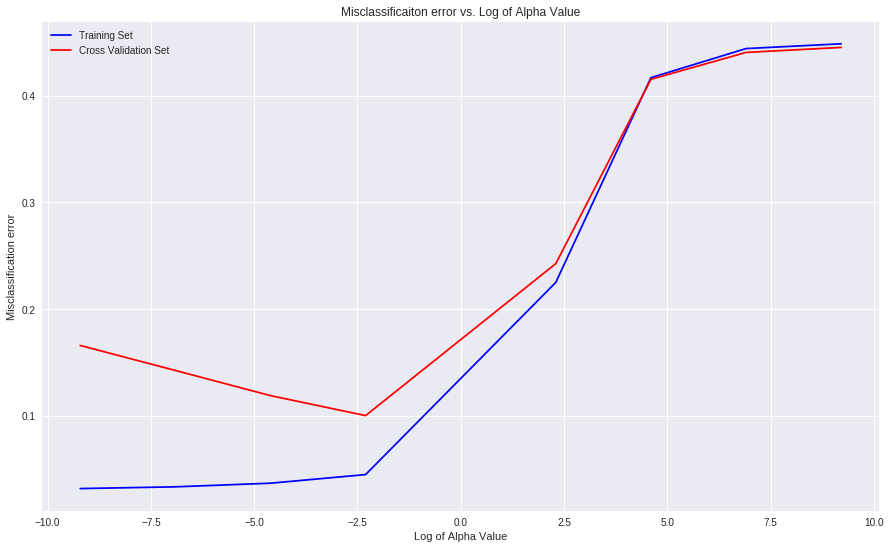

The optimal value of alpha is  0.1 with AUC Score : 0.9000181528357977


In [32]:


data=(BOW_TRAIN,Y_TRAIN,BOW_CV_TEST,Y_CV_TEST)
alpha=BEST_ALPHA(data)

**TESTING WITH OUR TEST DATA SET**

In [33]:

BOW_TEST=vectorizer.transform(BOW_TEST)
print(BOW_TEST.shape)




(30000, 22931)


Heat map for test data:

Heat map for train data:



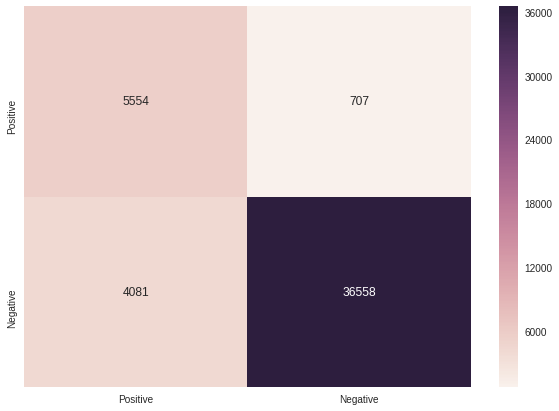

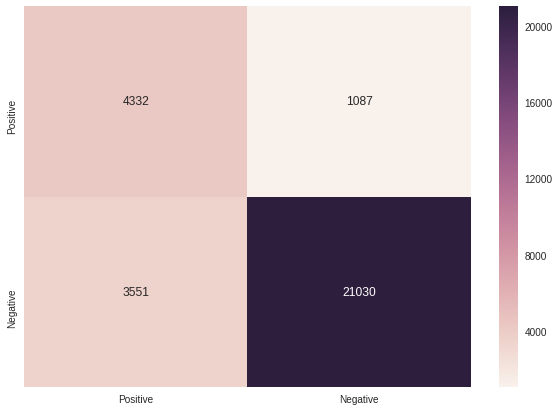

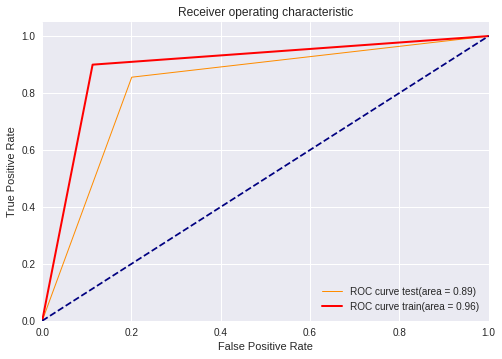

Time taken: 1.2287416458129883


In [34]:

data=(BOW_TRAIN,Y_TRAIN,BOW_TEST,Y_TEST)
x=nb_classifier(data,alpha)

In [35]:
print("The AUC score for BOW for alpha={} : {}".format(alpha,x[0]))

The AUC score for BOW for alpha=0.1 : 0.8942948515401952


**TOP 10 MOST IMPORTANT FEATURES**

In [36]:
def most_informative_feature_for_binary_classification(vectorizer, classifier):
	class_labels = classifier.classes_
	feature_names = vectorizer.get_feature_names()
	topn_class1 = sorted(zip(classifier.feature_log_prob_[0], feature_names), reverse=True)[:10]
	topn_class2 = sorted(zip(classifier.feature_log_prob_[1], feature_names), reverse=True)[:10]
	
	print("Top 10 negative features")
	for coef, feat in topn_class1:
		print(class_labels[0], coef, feat)
	

	print("Top 10 positive features")
	for coef, feat in reversed(topn_class2):
		print(class_labels[1], coef, feat)

most_informative_feature_for_binary_classification(vectorizer,x[1])

Top 10 negative features
0 -4.234338957428495 tast
0 -4.271477190610618 like
0 -4.331626717202055 product
0 -4.645532046377293 one
0 -4.815867684327014 tri
0 -4.854489856065589 would
0 -4.891309477645288 flavor
0 -4.921221299126028 good
0 -5.025884307004425 buy
0 -5.054644255937053 order
Top 10 positive features
1 -4.772502378207578 one
1 -4.762929166315445 product
1 -4.716008527453129 flavor
1 -4.643221305110854 use
1 -4.55871994891562 good
1 -4.541212754371459 tea
1 -4.535444478228987 love
1 -4.523217348741079 great
1 -4.490305599237109 tast
1 -4.448214109022025 like


**ADDING EXTRA FEATURE : LENGTH OF REVIEWS**

In [0]:
from scipy.sparse import coo_matrix, hstack

def review_len(x):
  
  return len(x)

feature_len=main_data['CleanedReview'][:70000]
feature_len=feature_len.apply(review_len)

feature_len=feature_len.reshape(70000,1)
print(feature_len)

BOW=hstack([BOW,feature_len])

BOW=BOW.tocsr()

[[191]
 [181]
 [ 85]
 ...
 [228]
 [ 47]
 [ 71]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.


Number of data points for TRAIN: 46900
Number of data points for CROSS VALIDATION 23100


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


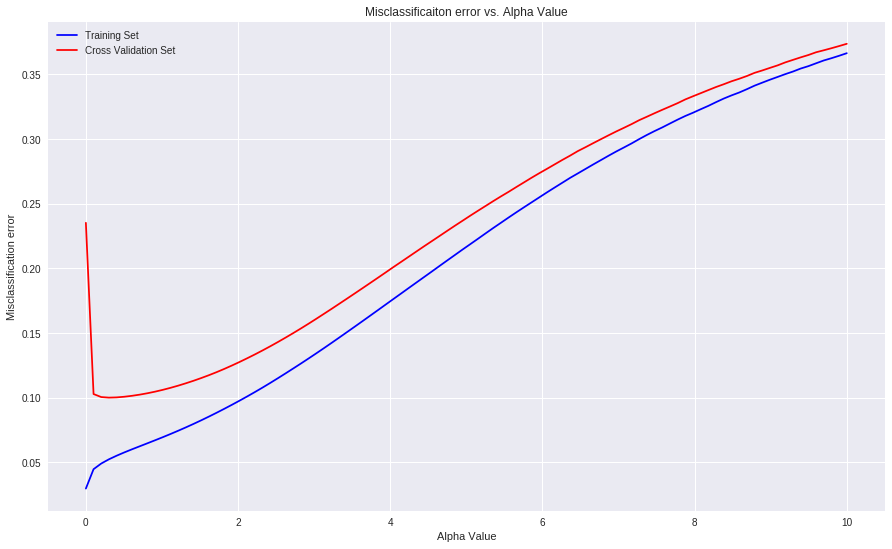

The optimal value of alpha is  0.30303030303030304 with AUC Score : 0.8998975059704678


In [0]:
BOW_TRAIN,BOW_CV_TEST,Y_TRAIN,Y_CV_TEST=random_splitter(BOW,Y_TRAIN)

print("Number of data points for TRAIN:",BOW_CV_TRAIN.shape[0])
print("Number of data points for CROSS VALIDATION",BOW_CV_TEST.shape[0])

data=(BOW_TRAIN,Y_TRAIN,BOW_CV_TEST,Y_CV_TEST)
alpha=BEST_ALPHA(data)

In [0]:
feature_len=main_data['CleanedReview'][70000:100001]
feature_len=feature_len.apply(review_len)
feature_len=np.array(feature_len)
feature_len=feature_len.reshape(30000,1)
print(feature_len.shape)
BOW_TEST=hstack([BOW_TEST,feature_len])

(30000, 1)


(30000,)
Time taken: 0.182173490524292


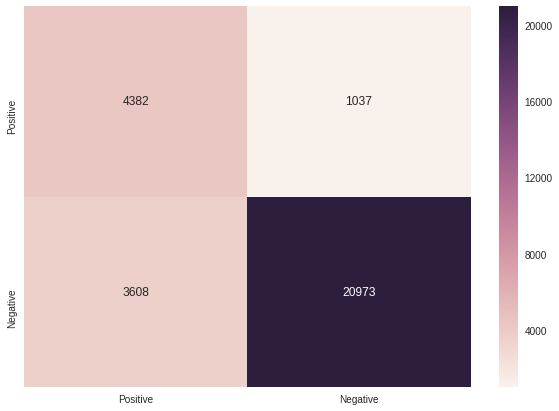

In [0]:

BOW_TEST=BOW_TEST.tocsr()

data=(BOW,Y_TRAIN,BOW_TEST,Y_TEST)
x_extra=nb_classifier(data,alpha)

In [0]:
print("The AUC score for BOW for alpha={} : {} with a additional feature".format(alpha,x_extra[0]))

The AUC score for BOW for alpha=0.30303030303030304 : 0.9002876210454218 with a additional feature


**OBSERVATIONS**

1.   THE OPTIMAL VALUE OF APLHA COMES OUT TO BE 0.3 WTH AUC-SCORE  OF 89.9%
2.   TOTAL  AUC-SCORE FOR TEST DATASET COMES OUT TO BE 90%
3.   ON ADDITING AN EXTRA FEATURE  THERE IS NO CHANGE IN THE AUC SCORE AS AFTER CHANGE AUC IS STILL 90%


# **NAIVE BAYES FOR TF-IDF**

In [37]:
tf_TRAIN,tf_TEST,Y_TRAIN,Y_TEST=splitter(reviews,Score)
TF_TRAIN,TF_CV_TEST,Y_TRAIN,Y_CV_TEST=random_splitter(tf_TRAIN,Y_TRAIN)

print("Number of data points for TRAIN:",TF_TRAIN.shape[0])
print("Number of data points for TEST",tf_TEST.shape[0])



Number of data points for TRAIN: 46900
Number of data points for TEST 30000


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer=TfidfVectorizer(ngram_range=(1,2))

TF_TRAIN=vectorizer.fit_transform(TF_TRAIN)
TF_CV_TEST=vectorizer.transform(TF_CV_TEST)




In [39]:
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

**SPLITTING DATA**

**FINDING OPTIMAL VALUE OF ALPHA**

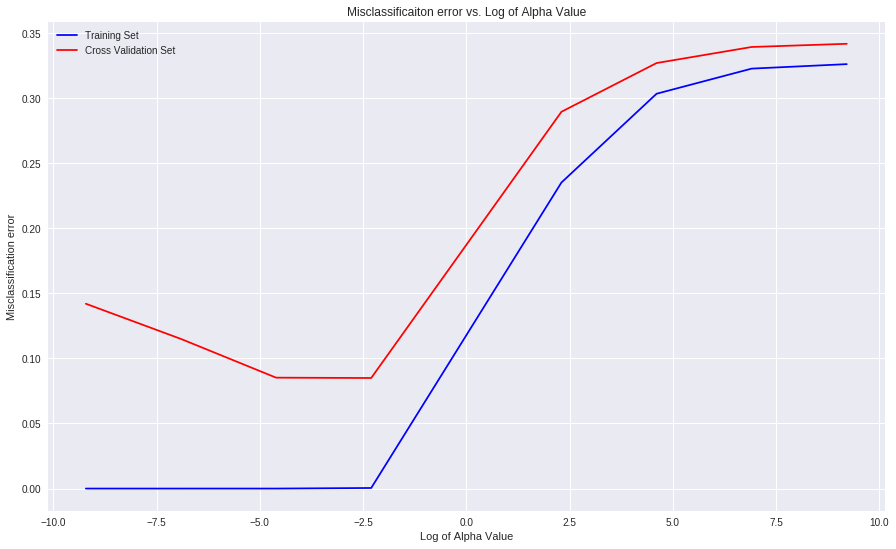

The optimal value of alpha is  0.1 with AUC Score : 0.9150783424155355


In [40]:

data=(TF_TRAIN,Y_TRAIN,TF_CV_TEST,Y_CV_TEST)
alpha=BEST_ALPHA(data)

**TRAINING AND TESTING DATA ON TEST DATA SET**

In [41]:


tf_TEST=vectorizer.transform(tf_TEST)
print(tf_TEST.shape)

(30000, 583223)


Heat map for test data:

Heat map for train data:



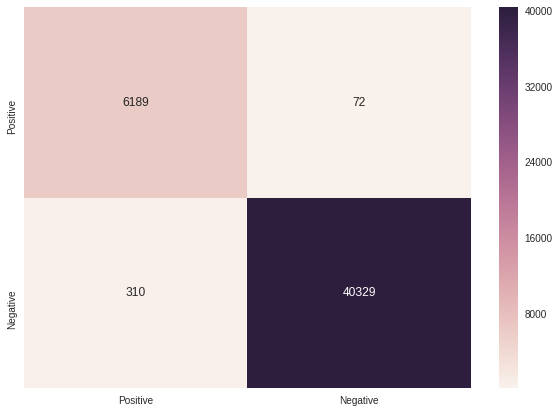

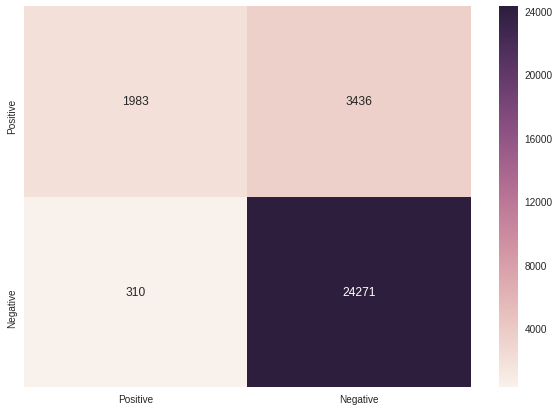

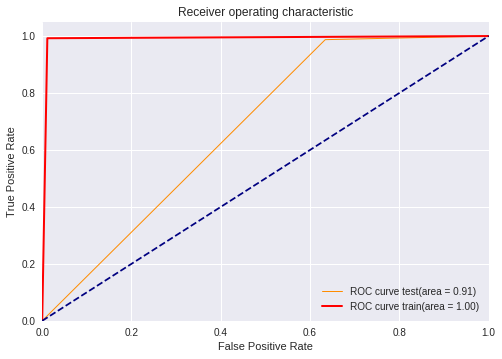

Time taken: 1.3128149509429932


In [42]:

data=(TF_TRAIN,Y_TRAIN,tf_TEST,Y_TEST)
auc=nb_classifier(data,alpha)

In [43]:
print("The AUC score for TF-IDF with alpha={} : {}:".format(alpha,auc[0]))

The AUC score for TF-IDF with alpha=0.1 : 0.9094492188807612:


**TOP 10 MOST IMPORTANT FEATURES**

In [21]:
def most_informative_feature_for_binary_classification(vectorizer, classifier):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.feature_log_prob_[0], feature_names), reverse=True)[:10]
    topn_class2 = sorted(zip(classifier.feature_log_prob_[1], feature_names), reverse=True)[:10]

    print("Top 10 negative features")
    for coef, feat in topn_class1:
       print(class_labels[0], coef, feat)

    print("************************")
    print("Top 10 positive features")
    for coef, feat in reversed(topn_class2):
      print(class_labels[1], coef, feat)
        

most_informative_feature_for_binary_classification(vectorizer,auc[1])

Top 10 negative features
0 -6.7995277436298505 tast
0 -6.85020568730805 product
0 -6.869303054635798 like
0 -7.199409353953384 one
0 -7.212766281646616 would
0 -7.3440242621188645 buy
0 -7.353001240306909 order
0 -7.3569917609215825 tri
0 -7.3765137569796595 flavor
0 -7.44715927378281 tea
************************
Top 10 positive features
1 -6.647622457248649 one
1 -6.51905499424043 flavor
1 -6.505399309021747 use
1 -6.4997498616410505 product
1 -6.403745258149751 like
1 -6.38105246268539 tast
1 -6.357902737003476 good
1 -6.286421196500311 love
1 -6.254525266765561 great
1 -6.179386327875311 tea


**ADDING ADDITIONAL FEATURES:LENGTH OF REVIEWS**

In [0]:
from scipy.sparse import coo_matrix, hstack

def review_len(x):
  
  return len(x)

feature_len=main_data['CleanedReview'][:70000]
feature_len=feature_len.apply(review_len)

feature_len=feature_len.reshape(70000,1)
print(feature_len)

tf_idf=hstack([tf_idf,feature_len])

tf_idf=tf_idf.tocsr()


[[191]
 [181]
 [ 85]
 ...
 [228]
 [ 47]
 [ 71]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.


Number of data points for TRAIN: 46900
Number of data points for CV-TEST 23100


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


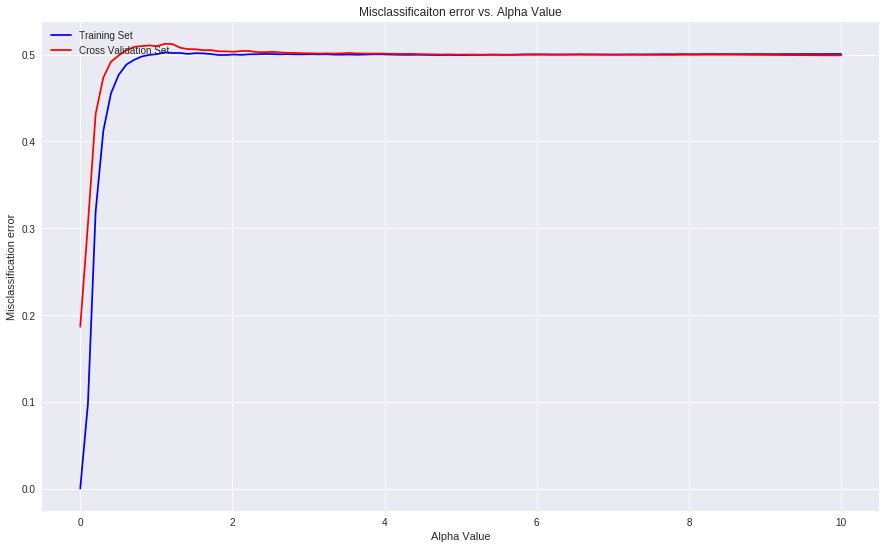

The optimal value of alpha is  0.0 with AUC Score : 0.8135365750312624


In [0]:
TF_TRAIN,tf_CV_TEST,Y_TRAIN,Y_CV_TEST=random_splitter(tf_idf,Y_TRAIN)

print("Number of data points for TRAIN:",tf_CV_TRAIN.shape[0])
print("Number of data points for CV-TEST",tf_CV_TEST.shape[0])


data=(TF_TRAIN,Y_TRAIN,tf_CV_TEST,Y_CV_TEST)
alpha=BEST_ALPHA(data)

In [0]:
feature_len=main_data['CleanedReview'][70000:100001]
feature_len=feature_len.apply(review_len)
feature_len=np.array(feature_len)
feature_len=feature_len.reshape(30000,1)
print(feature_len.shape)
tf_TEST=hstack([tf_TEST,feature_len])

(30000, 1)


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


(30000,)
Time taken: 0.27544355392456055


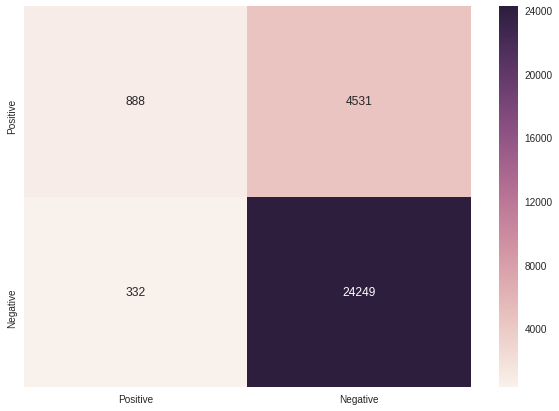

In [0]:
tf_TEST=tf_TEST.tocsr()

data=(tf_idf,Y_TRAIN,tf_TEST,Y_TEST)
x_extra=nb_classifier(data,alpha)

In [0]:
print("The AUC score for TF-IDF for alpha={} : {} with a additional feature".format(alpha,x_extra[0]))

The AUC score for TF-IDF for alpha=0.0 : 0.7863686810016893 with a additional feature


**OBSERVATIONS**

1.   THE OPTIMAL VALUE OF APLHA COMES OUT TO BE 0.1 WTH AUC-SCORE  OF 89.3%.
2.   TOTAL  AUC-SCORE FOR TEST DATASET COMES OUT TO BE 90.5%.
3.   ON ADDITING AN EXTRA FEATURE  THERE IS A DROP OF ALMOST 12% IN THE AUC score.

In [22]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Text To Vector", "With additonal feature or not ", "Alpha","AUC Score"]

x.add_row(["BOW", "NO", 0.1, "90%" ])
x.add_row(["BOW", "YES", 0.3, "90%"])
x.add_row(["TFIDF", "NO", 0.10,"91.5%" ])
x.add_row(["TFIDF", "YES", 0.0,"78.6%"])


print(x)

+----------------+--------------------------------+-------+-----------+
| Text To Vector | With additonal feature or not  | Alpha | AUC Score |
+----------------+--------------------------------+-------+-----------+
|      BOW       |               NO               |  0.1  |    90%    |
|      BOW       |              YES               |  0.3  |    90%    |
|     TFIDF      |               NO               |  0.1  |   91.5%   |
|     TFIDF      |              YES               |  0.0  |   78.6%   |
+----------------+--------------------------------+-------+-----------+


# **CONCLUSION**



1.   THE DATA WAS FOUND TO BE IMBALANCED AND THUS AUC SCORE WAS THE APPROPRIATE METRIC 
2.   THE OPTIMAL VALUE OF APLHA VARIED SLIGHTLY FOR THE BOTH THE MODEL
3.   THERE IS A SIGNIFICANT DECREASE THE AUC SCORE WHEN ADDITONAL FEATURE ,LENGTH OF REVIEWS IS ADDED FOR TF-IDF BUT NO CHANGE FOR BOW
4.   THE HIGHEST AUC-SCORE WAS NOTED TO BE 91.5% FOR TF-IDF
5.   THE TENTATIVE AUC SCORE WAS FOUND TO BE AROUND 90%
6.   THERE WAS SIGNIFICANT CHANGE IN THE AUC FOR TFIDF WHEN AN ADDITIONAL FEATURE WAS ADDED

